In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import utils
from data_utils import CustomDataset
from MLP_utils import SimpleMLP, LNLoss
import random
from pathlib import Path
import tempfile
from ray.train import CheckpointConfig
from ray import tune, train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler, FIFOScheduler
import ray.cloudpickle as pickle
import os

def fix_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

fix_seed(utils.SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

DIRPATH_EXTRACTED_FEATURES = "extracted_features"

cuda


In [2]:
filenames_features = [utils.FILENAME_BRAND_OHE,
utils.FILENAME_PUBLICATION_TIMESTAMP,
utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
utils.FILENAME_NUM_WORDS,
utils.FILENAME_NUM_PARAGRAPH,
# utils.FILENAME_SUBSECTIONS_OHE,
# utils.FILENAME_SUBSECTIONS_OHE,
utils.FILENAME_MAIN_SECTION_EMB,
utils.FILENAME_SUBSECTIONS_EMB,
# utils.FILENAME_MAIN_SECTION_SUBSECTIONS_MEAN_EMB,
utils.FILENAME_USER_NEEDS,
utils.FILENAME_LDA_TOPICS,
utils.FILENAME_IPTC_TOPICS_LEVEL_0,
utils.FILENAME_IPTC_TOPICS_LEVEL_1,
utils.FILENAME_TITLE_EMB,
utils.FILENAME_AUTHOR_OHE
]

brands = utils.ALL_BRANDS

# brands = ['parool']

customdataset_kwargs = dict(
                        brands=brands, 
                        filenames_features=filenames_features, 
                        dirpath_extracted_features=DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=True, 
                        center_target=True,
                        filter_uniform_features=False, 
                        max_datapoints=None)
try:
    dataset = CustomDataset(**customdataset_kwargs)
except torch.cuda.OutOfMemoryError as e:
    print("There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.")
    customdataset_kwargs['device'] = torch.device('cpu')
    dataset = CustomDataset(**customdataset_kwargs)
    
dataset.features.shape[1], dataset.device

There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.


(3565, device(type='cpu'))

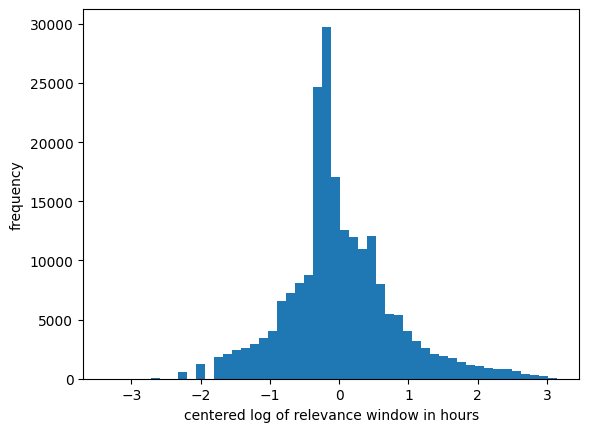

In [3]:
plt.hist(dataset.target.cpu(), bins=50)
plt.ylabel("frequency")
plt.xlabel("centered log of relevance window in hours")
plt.show()

In [4]:
def train_MLP(config, dataset):
    # fix seed again because Ray Tune seems to change the seed
    fix_seed(utils.SEED)
    hidden_sizes = config["depth"] * [config["width"]]

    model = SimpleMLP(input_size=config["input_size"], hidden_sizes=hidden_sizes, output_size=1, batchnorm=True)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    if config["raytune"]:
        checkpoint = get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
                start_epoch = checkpoint_state["epoch"]
                model.load_state_dict(checkpoint_state["model_state_dict"])
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
        else:
            start_epoch = 0
    else:
        train_loss_epochs = []
        val_loss_epochs = []
        start_epoch = 0

    train_val_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
    train_dataset, val_dataset = random_split(train_val_dataset, [8/9, 1/9])

    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    min_val_loss = float('inf')
    for epoch in range(start_epoch, config["max_epochs"]):  # loop over the dataset multiple times
        train_loss = 0.0
        train_steps = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_steps += 1
            train_loss += loss
        train_loss_epoch = (train_loss / train_steps).item()


        # Validation loss
        val_loss = 0.0
        val_steps = 0
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                val_loss += vloss
                val_steps += 1
            val_loss_epoch = (val_loss / val_steps).item()
        

        if config["raytune"]:
            with tempfile.TemporaryDirectory() as checkpoint_dir:
                train.report(
                    {"loss": val_loss_epoch},
                )
        else:
            train_loss_epochs.append(train_loss_epoch)
            val_loss_epochs.append(val_loss_epoch)

        if config["verbose"]:
            print(f"finished epoch {epoch+1}/{config['max_epochs']} with eval loss {val_loss_epoch:.3f}")

        # Stop trial if validation loss doesn't improve
        if val_loss_epoch < min_val_loss:
            min_val_loss = val_loss_epoch
            counter = 0
        else:
            counter += 1
            if counter == config["patience"]:
                break
        
    if not config["raytune"]:
        return model, train_loss_epochs, val_loss_epochs


In [5]:
# Choose amount of trials you want to run
num_samples=2

if device == torch.device('cuda'):
    gpus_per_trial = torch.cuda.device_count()
else:
    gpus_per_trial = 0
cpus_per_trial = 8

config = {
    "depth": tune.randint(2, 6),
    "width": tune.choice([32, 64, 128, 256]),
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": 1024,
    "max_epochs": 50,
    "patience": 3, 
    "raytune":True, 
    "verbose":False, 
    "input_size": dataset.features.shape[1]
}

scheduler = FIFOScheduler()

result = tune.run(
    tune.with_parameters(train_MLP, dataset=dataset),
    resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
)

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")

# fix seed again because Ray Tune seems to change the seed
fix_seed(utils.SEED)

2025-01-28 20:25:38,096	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2025-01-28 20:25:45,530	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-01-28 20:25:45,681	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) Spilled 2903 MiB, 1 objects, write throughput 549 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


Trial name,loss
train_MLP_ac089_00000,0.390316
train_MLP_ac089_00001,0.393881


(raylet) [2025-01-28 20:26:38,033 E 18106 18106] node_manager.cc:3180: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: b628dbe81e6d2fbda0a4f5f5b0f59fd8d0a71608a7af30c65e55e2cd, IP: 192.168.178.16) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.178.16`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
2025-01-28 20:27:21,610	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/j

Best trial config: {'depth': 2, 'width': 256, 'lr': 5.2042862764261096e-05, 'batch_size': 1024, 'max_epochs': 50, 'patience': 3, 'raytune': True, 'verbose': False, 'input_size': 3565}
Best trial final validation loss: 0.39031562209129333


In [6]:
retrain_config = best_trial.config
retrain_config["raytune"] = False
retrain_config["verbose"] = True

In [7]:
# Train again with the best hyperparameters
model, train_loss, val_loss = train_MLP(config=retrain_config, dataset=dataset)


finished epoch 1/50 with eval loss 0.480
finished epoch 2/50 with eval loss 0.436
finished epoch 3/50 with eval loss 0.418
finished epoch 4/50 with eval loss 0.413
finished epoch 5/50 with eval loss 0.403
finished epoch 6/50 with eval loss 0.399
finished epoch 7/50 with eval loss 0.403
finished epoch 8/50 with eval loss 0.399
finished epoch 9/50 with eval loss 0.396
finished epoch 10/50 with eval loss 0.396
finished epoch 11/50 with eval loss 0.389
finished epoch 12/50 with eval loss 0.390
finished epoch 13/50 with eval loss 0.392
finished epoch 14/50 with eval loss 0.390


In [8]:
def save_model(model, config, model_name, overwrite=False):
    dir_path = os.path.join('models', model_name)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    elif not overwrite:
        raise Exception(f"Model name already used. Call save_model with overwrite=True to overwrite.")
    
    torch.save(model.state_dict(), os.path.join(dir_path, 'state_dict.pth'))
    with open(os.path.join(dir_path, 'config.pkl'), "wb") as fp:
        pickle.dump(config, fp)


def load_model(model_name):
    dir_path = os.path.join('models', model_name)

    if not os.path.exists(dir_path):
        raise Exception(f"No such model. Available models: {os.listdir('models')}.")
    
    with open(os.path.join(dir_path, 'config.pkl'), "rb") as fp:
        config = pickle.load(fp)

    hidden_sizes = config["depth"] * [config["width"]]
    model = SimpleMLP(input_size=config["input_size"], hidden_sizes=hidden_sizes, output_size=1, batchnorm=True)
    model.load_state_dict(torch.load(os.path.join(dir_path, 'state_dict.pth'), weights_only=True))
    model.eval()
    return model, config

In [9]:
# Save model
save_model(model, retrain_config, 'test')

Exception: Model name already used. Call save_model with overwrite=True to overwrite.

In [10]:
# Load model
model, config = load_model('test')

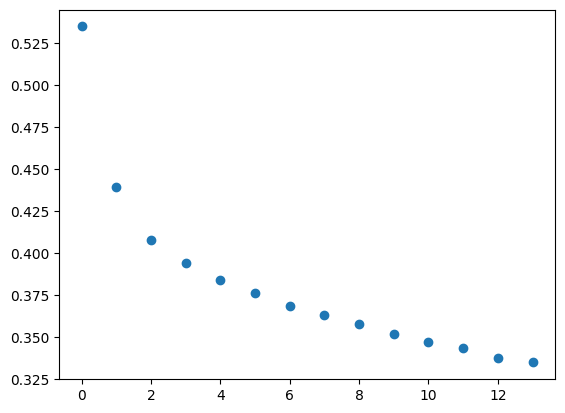

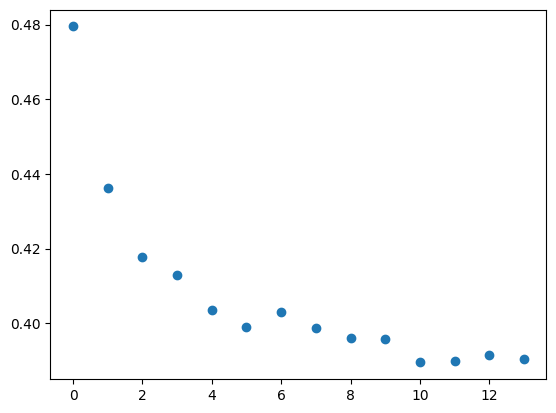

In [11]:
plt.scatter(range(len(train_loss)), train_loss)
plt.show()
plt.scatter(range(len(val_loss)), val_loss)
plt.show()

In [12]:
train_val_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataset, val_dataset = random_split(train_val_dataset, [8/9, 1/9])

with torch.no_grad():
    model.eval()
    metric = nn.MSELoss(reduction='none')
    y_train = dataset[train_dataset.indices][1].cpu()
    y_pred_train = model(dataset[train_dataset.indices][0]).cpu()
    abs_dif_train = metric(y_pred_train, y_train)

    y_test = dataset[test_dataset.indices][1].cpu()
    y_pred_test = model(dataset[test_dataset.indices][0]).cpu()
    abs_dif_test = metric(y_pred_test, y_test)

In [13]:
# import math
# metric = nn.L1Loss(reduction='none')
# target_test = test_dataset.dataset[test_dataset.indices][1] + dataset.centering_shift
# baseline = torch.full_like(target_test, math.log(24))
# baseline_metric = metric(target_test, baseline)
# print(baseline_metric.mean(), baseline_metric.std())


tensor(0.3648) tensor(0.8020)
tensor(0.3737) tensor(0.7888)


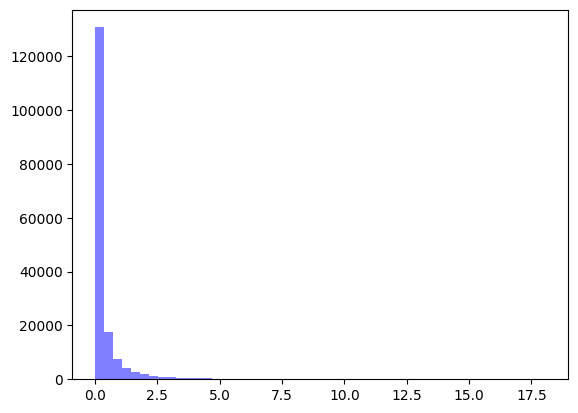

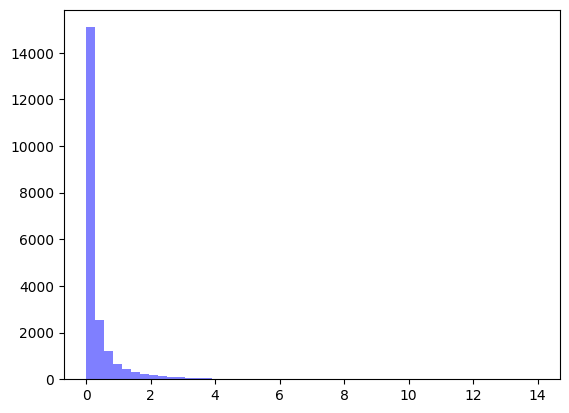

In [14]:
print(abs_dif_train.mean(), abs_dif_train.std())
print(abs_dif_test.mean(), abs_dif_test.std())
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.show()

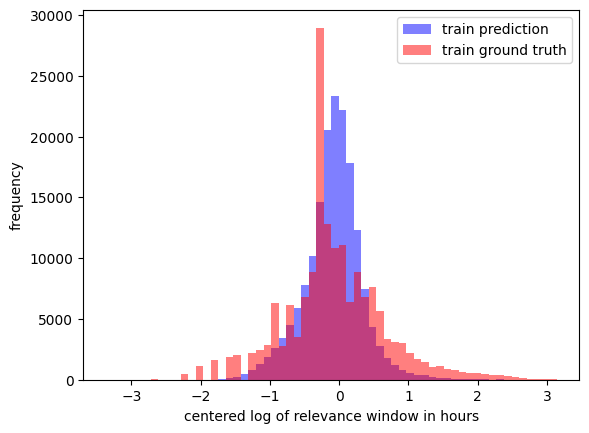

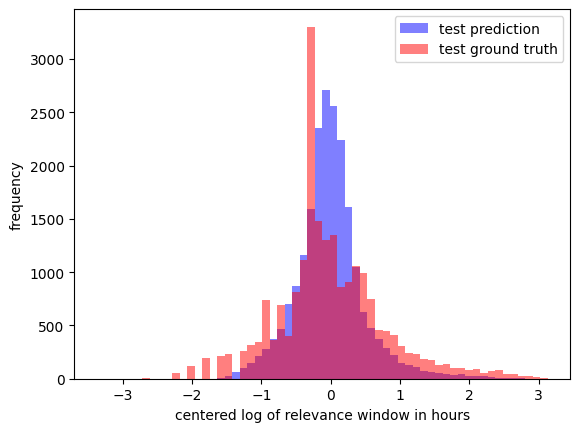

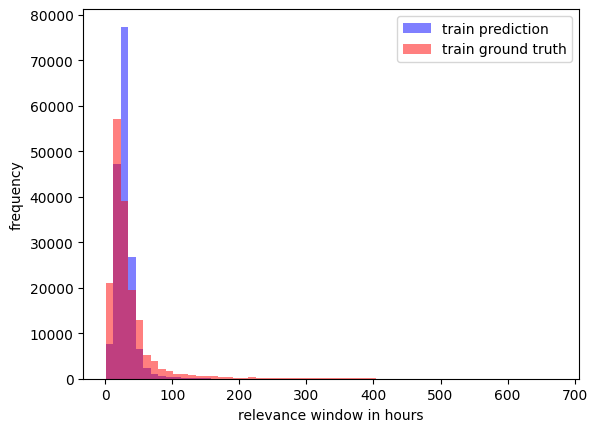

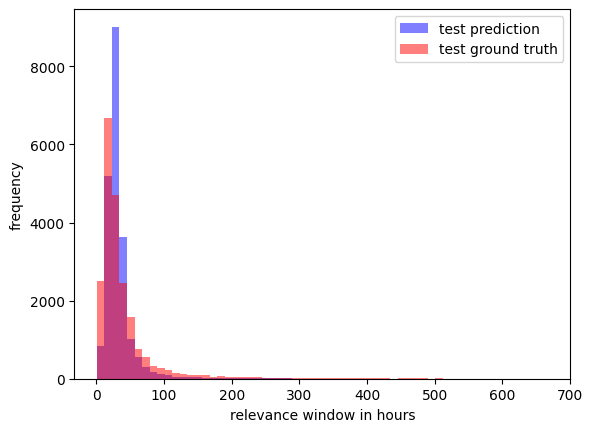

In [15]:
n_bins = 60
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.xlabel("centered log of relevance window in hours")
plt.ylabel("frequency")
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.xlabel("centered log of relevance window in hours")
plt.ylabel("frequency")
plt.show()

y_pred_train_trans = y_pred_train
y_train_trans = y_train
y_pred_test_trans = y_pred_test
y_test_trans = y_test

if dataset.center_target:
    centering_shift = dataset.centering_shift.cpu()
    y_pred_train_trans = y_pred_train_trans + centering_shift
    y_train_trans = y_train_trans + centering_shift
    y_pred_test_trans = y_pred_test_trans + centering_shift
    y_test_trans = y_test_trans + centering_shift
if dataset.log_target:
    y_pred_train_trans = torch.exp(y_pred_train_trans)
    y_train_trans = torch.exp(y_train_trans)
    y_pred_test_trans = torch.exp(y_pred_test_trans)
    y_test_trans = torch.exp(y_test_trans)
else:
    y_pred_train_trans = torch.log(y_pred_train_trans)
    y_train_trans = torch.log(y_train_trans)
    y_pred_test_trans = torch.log(y_pred_test_trans)
    y_test_trans = torch.log(y_test_trans)


bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.xlabel("relevance window in hours")
plt.ylabel("frequency")
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.xlabel("relevance window in hours")
plt.ylabel("frequency")
plt.show()